# 线性回归
<!-- 
Author: Zhaoqiang SHEN
Date: 2018/08/22
Contact: szqtclx@gmail.com

TODO LISTS:
1. 讨论metrics
2. train test split
3. 核技巧举例
4. tensorflow使用例
5. 多分类问题
6. unbalanced datasets
-->

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# scikit-learn
from sklearn import linear_model 
from sklearn import metrics

# tensorflow
import tensorflow as tf

/home/szqtc/Softwares/Anaconda/INSTALLED/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 线性模型
线性模型：$f({\bf x}) = w_1 x_1 + w_2 x_2 + \cdots + w_d x_d + b = {\bf x}^T { \bf \hat w}$，其中${\bf \hat w}=({\bf w}; b) = (w_1, w_2, \cdots, b)^T$。  
损失函数（欧几里得距离）：
$J({\bf \hat w}) = \sum_{i=1}^{m} [ f({\bf x}^{(i)}; {\bf \hat w}) - y^{(i)} ]^2 = ({\bf Xw-y})^T({\bf Xw-y})$。  
最小化损失函数可得模型参数：
$\boxed{ {\bf \hat w}^\star = ({\bf X}^T {\bf X})^{-1} {\bf X}^T {\bf y}}$, 其中${\bf X}=({\bf x}_1^{T}; {\bf x}_2^{T}; \cdots; {\bf x}_m^{T})$。

### 线性回归的特点
优点：结果易于理解，计算上不复杂。  
缺点：对非线性的数据拟合不好。  
适用于数据类型：数值型和标称型数据。  

In [2]:
# 准备数据
raw_data = np.loadtxt('datasets/MLiA/Ch08/ex0.txt') # Machine Learning in Action, Chap8
X = raw_data[:, :-1] # (1., x_1, x_2, ...) for each vector
y = raw_data[:, -1]

In [3]:
w = np.linalg.inv(X.T @ X) @ X.T @ y
w

array([3.00774324, 1.69532264])

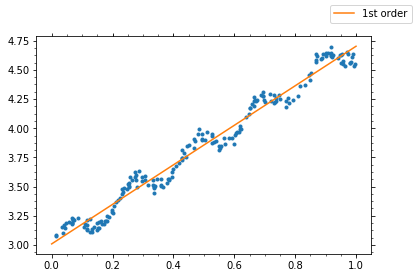

In [4]:
fg0 = plt.figure()
ax0 = fg0.add_subplot(111)
ax0.plot(X[:, 1], y, marker='o', ms=3, ls='None')
ax0.plot([0., 1.], np.array([[1, 0], [1, 1]])@w.reshape(2, 1), ls='-', label='1st order')
fg0.legend()

In [5]:
#拟合优度
## RSE
y_pred = X@w # a@b=np.dot(a, b) for Python 3
RSS = ((y_pred-y)**2).sum()
print('RSS=', RSS)
print('RSE=', np.sqrt(RSS/(len(y_pred)-2)))

## R^2
TSS = ((y-y.mean())**2).sum()
print("R2=", 1-RSS/TSS)

RSS= 1.3552490816814913
RSE= 0.08273265577584647
R2= 0.9731300889856915


#### sklearn

In [6]:
lin = linear_model.LinearRegression()
lin.fit(X[:, 1:], y)
print(lin.intercept_, lin.coef_) # b, w

3.007743242697591 [1.69532264]


### 正则化
$J({\bf w}) =\Omega(f) + C/m \sum_{i=1}^m \ell(f({\bf x}_i), y_i) $，后者是经验风险（描述模型与训练数据的契合度），前者是结构风险（引入模型结构因素后的总体风险）。$C$是正则化常数，正则化项通常为$L_p$范数$\equiv \| {\bf w} \|_p$，$L_2$使得分量取值均衡、非零分量稠密，$L_1$和$L_0$使非零分量尽量少。而后者常用于特征选择（属于嵌入式特征选择，特征选择和模型学习过程一同进行）。

#### 欧几里得距离 + L2正则项

$J({\bf \hat w}) = C/m ({\bf Xw-y})^T({\bf Xw-y}) + {\bf w}^T{\bf w}$，  
易得，
$\boxed{ {\bf \hat w}^\star = ({\bf X}^T {\bf X} + m/C \, {\bf I})^{-1} {\bf X}^T {\bf y}}$。（当不对截距项限制时，将截距对应的单位矩阵中的元素置为0）

1. 由于正则化项的存在，使得${\bf w}_{i+1} = {\bf w}_i -\eta \nabla_{{\bf w}_i} J = (1-\eta m/C){\bf w}_i + \cdots$，即每一步相对于上一步参数值有缩减。
2. ${\bf I}$项使得原来可能不可逆的矩阵变得可逆。

#### 近端梯度下降

找个二阶导的最大值。

### 线性基函数 （Linear Basis Function）
在某些情况下，特征无法线性可分。此时可以通过将特征向量投影到更高维特征空间（${\bf x} \to \phi({\bf x})$）来使问题可分，其中集合$\{ \phi_i({\bf x})\}$称为**基函数**。  
对于已知的基函数，新的模型可写为：$f({\bf x}) = \sum_j w_j \phi_j({\bf x}) = {\bf\phi(x)}^T\,{\bf \hat w} $，其中$\phi({\bf x})=(\phi_1({\bf x}), \phi_2({\bf x}), \cdots, \phi_n({\bf x}))^T$。  
假设损失函数是欧几里得距离，可解得参数：
${\bf \hat w}^\star = ({\bf \Phi}({\bf X})^T {\bf \Phi}({\bf X}))^{-1} {\bf \Phi}({\bf X})^T {\bf y}$，其中${\bf \Phi}({\bf X}) = (\phi({\bf x}_1)^T; \phi({\bf x}_2)^T; \cdots; \phi({\bf x}_m)^T)$。  
最终模型为：
$\boxed{f({\bf x}) = {\bf \phi}({\bf x})^T {\bf \hat w}^\star = \phi({\bf x})^T \Phi({\bf X})^T (\Phi({\bf X}) \Phi({\bf X})^T)^{-1} {\bf y} = \kappa({\bf X, x}) \kappa({\bf X, X}) ^{-1} {\bf y}  }$ (规范正交基)

下面以多项式基函数$\phi_j(x) = x^j, (j=0,1,2,3)$为例：
<!-- $f({\bf x}) = {\bf \phi}({\bf x})^T {\bf \hat w}^\star = \phi({\bf x})^T {\bf \phi}({\bf X}) {\bf y}$ -->

In [7]:
X_lb = np.c_[X, X[:, 1]**2, X[:, 1]**3] # xm = (1, xm, xm^2, xm^3)
w_lb = np.linalg.inv(X_lb.T @ X_lb) @ X_lb.T @ y
w_lb

array([ 3.07420047,  0.99248267,  1.66903408, -1.07368127])

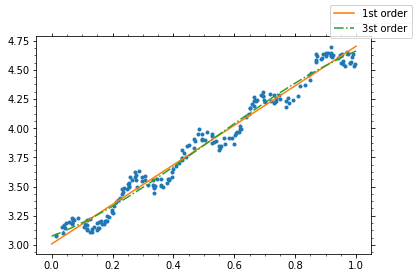

In [8]:
x_lb = np.linspace(0, 1, 100)
y_lb_pred = np.c_[np.ones_like(x_lb), x_lb, x_lb**2, x_lb**3] @ w_lb
ax0.plot(x_lb, y_lb_pred, ls='-.', label='3st order')
fg0.legend()
fg0

In [9]:
## RSE
y_pred = X_lb@w_lb
RSS = ((y_pred-y)**2).sum()
print('RSS=', RSS)
print('RSE=', np.sqrt(RSS/(len(y_pred)-2)))

## R^2
TSS = ((y-y.mean())**2).sum()
print("R2=", 1-RSS/TSS)

RSS= 1.2765005444945323
RSE= 0.08029304108664762
R2= 0.9746914006407382


#### sklearn

In [10]:
lin2 = linear_model.LinearRegression()
lin2.fit(X_lb[:, 1:], y)
print(lin2.intercept_, lin2.coef_) # b, w

3.074200469003543 [ 0.99248267  1.66903408 -1.07368127]


### 核技巧
核函数可以通过基函数内积获得，即$\kappa({\bf x}_1, {\bf x}_2) = \phi({\bf x}_1)^T \phi({\bf x}_2)$。但当特征空间维度很高时，计算基函数间的内积将很耗计算时间。但是，下面两定理让我们可以完全回避掉基函数。通过直接使用核函数来替代基函数内积，我们隐式地在高维特征空间中学习线性模型，这个方法称为**核技巧**：

**核函数**：（定理6.1）令$\mathcal{X}$为输入空间，$\kappa(\cdot, \cdot)$是定义在$\mathcal{X} \times \mathcal{X}$上的对称函数，则$\kappa$是核函数当且仅当对于**任意**数据$D=\{{\bf x}_1, {\bf x}_2, \cdots, {\bf x}_m\}$，核矩阵$K$总是*半正定*的：$K = (\kappa({\bf x}_i, {\bf x}_j))$。  
也就是说，对称函数的半正定矩阵总能作为核函数使用，并且隐式地定义了一个名为**再生核希尔伯特空间**的特征空间。

**表示理论**：令${\Bbb H}$为核函数$\kappa$对应的再生核希尔伯特空间，$\|h\|_{\Bbb H}$表示${\Bbb H}$空间中关于$h$的范数，对于任意单调递增函数$\Omega: [0,\infty] \mapsto {\Bbb R}$和任意非负损失函数$\ell: {\Bbb R}^m \mapsto [0, \infty]$，优化问题 
$\min_{h \in {\Bbb H}} F(h) = \Omega(\|h\|_{\Bbb H})  +  \ell(h({\bf x}_1), h({\bf x}_2), \cdots, h({\bf x}_m))$
的解总可以写为
$h^\star({\bf x}) = \sum_{i=1}^m \alpha_i \kappa({\bf x}, {\bf x}_i)$。  
也就是说，对于一般的损失函数和正则项，上述优化问题的最优接总可写成核函数的线性组合的形式。

核函数包括：
- 常用核函数：


 名称             |                             $\kappa({\bf x}_i,{\bf  x}_j)$表达式                       | 参数 
--------------|-------------------------------------------------------------------------|-------
线性核           | $ {\bf x}_i^T {\bf x}_j$                                                                      |
多项式核       |  $ (\gamma {\bf x}_i^T {\bf x}_j + r)^d$                                          | $d \geq 1$
高斯核/RBF核| $\exp \left (-\frac{\| {\bf x}_i - {\bf x}_j \|^2}{2\sigma^2} \right )$  | $\sigma > 0$
拉普拉斯核    | $\exp \left (-\frac{\| {\bf x}_i - {\bf x}_j \|}{\sigma} \right )$             | $\sigma > 0$
Sigmoid核    | $\tanh (\beta {\bf x}_i^T {\bf x}_j + \theta)$                                    | $\beta>0,\theta<0$


- 常用核函数的组合：
    + 线性组合：$\gamma_1 \kappa_1 + \gamma_2 \kappa_2$，($\gamma_1, \gamma_2 > 0$)
    + 直积：$ \kappa_1({\bf x, z}) \otimes  \kappa_2({\bf x, z})$
    + 线性变换：$g(\bf x) \kappa({\bf x, z}) g({\bf z})$，($g({\bf x})$为任意函数)
    

In [11]:
# TODO: example

## 广义线性模型(Generalized Linear Models, GLMs)
参数$\eta$的**指数分布簇**(Exponential family)：$ p(y; \eta) = b(y) \exp(\eta^T T(y) - a(\eta)) $，其中$\eta$是分布的参数；$T(y)$是**充分统计量**(sufficient statistic)；$a(\eta)$是**对数配分函数**(log partition function)，用于归一化。给定一组$T, a, b$，就定义了一个参数为$\eta$的指数分布簇。  
伯努利分布，高斯分布，多项分布，泊松分布等分布都是指数分布族。

广义线性模型满足：
1. $y \mid x; \theta$服从参数$\eta$的指数分布簇。
3. 参数$\eta$与输入值$x$线性相关：$\eta=\theta^T x$。
2. 预测的目标：给定$\eta$后的充分统计量$T(y)$的期望$g(y) = E[T(y); \eta]$，其中$g(\cdot)$称为**联系函数**（link function）。通常$T(y)=y$ 。

### 对数几率（Logistic）回归  
**几率**指事件发生的概率与不发生的概率的比值。设事件$y=1$发生的概率为$p = p(y=1 \mid {\bf x})$, 因此对数几率（logit）写作为$\ln (p/(1-p))$。对于对数几率回归，输出$y=1$的对数几率是输入的线性函数（因此对数几率回归是一个广义线性模型），或$p=1/[1+\exp(-{\bf \hat w}^T {\bf x})]$。  
损失函数正比于伯努利分布样本的对数似然函数：
$J({\bf \hat w}) = -1/m \sum_{i=1}^{m} [ y_i \ln p_i + (1-y_i) \ln (1-p_i) ]$。  
因此，对数几率回归的梯度下降可写为：$\boxed{w_{i+1} = w_{i} - \eta \nabla_{\bf w}J = w_i + \eta {\bf X}^T ({\bf y} - {\bf p}) / m}$，其中$\nabla_{\bf w} p = {\bf x}^T \cdot (p(1-p))$。

#### 对数几率回归的特点
优点: 计算代价不高，易于理解和实现。  
缺点: 容易欠拟合，分类精度可能不高。  
适用数据类型: 数值型和标称型数据。

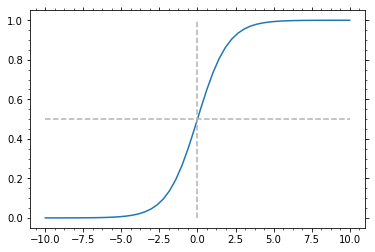

In [12]:
# Logistc function
x_ = np.linspace(-10., 10., 50)
fg3 = plt.figure()
ax3 = fg3.add_subplot(111)
ax3.plot(x_, 1./(1.+np.exp(-x_)))
ax3.plot([0., 0.], [0., 1.], ls='--', c='0.7')
ax3.plot([-10., 10.], [0.5, 0.5], ls='--', c='0.7')

#### 下面是个例子

In [13]:
# 西瓜书 数据3.0alpha
!cat wm3alpha.dat

cat: wm3alpha.dat: No such file or directory


In [14]:
raw_data2 = np.loadtxt('datasets/wm3alpha.dat')
X2 = raw_data2[:, 1:-1]
y2 = raw_data2[:, -1:]
print(X2.shape, y2.shape)

(17, 2) (17, 1)


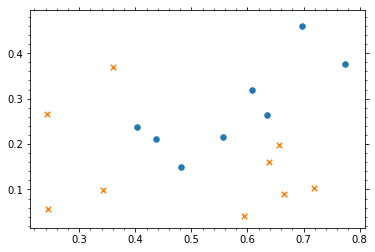

In [15]:
fg = plt.figure()
ax = fg.add_subplot(111)
ax.scatter(X2[:8, 0], X2[:8, 1], marker='o', s=30)
ax.scatter(X2[8:, 0], X2[8:, 1], marker='x', s=30)
#fg.show()

In [16]:
def logistic_model(X, w):
    """
    The model of Logistic regression
    
    Parameter
    -----------
    X : (m, n+1) array
        m training samples with n features
        x=(1, x_1, x_2, ..., x_n)
    w : (n+1, 1) array
        weights (b, w_1, w_2, ..., w_n)
        
    Returns
    ---------
    y_pred : (m, 1) array
        predicted labels
    """
    return 1./(1.+np.exp(-X@w))

def logistic_loss(X, y, w):
    """
    Parameter
    -----------
    X : (m, n+1) array
        m training samples with n features
        x=(1, x_1, x_2, ..., x_n)
    y : (m, 1) array, yi=0 or 1
        the labels of m training samples
    w : (n+1, 1) array
        weights (b, w_1, w_2, ..., w_n)
    
    Returns
    ---------
    loss : scalar
        the log likelihood per sample
    """
    p = logistic_model(X, w)
    loss = -(y*np.log(p) + (1-y)*np.log(1.-p)).mean()
    return loss

In [17]:
# learning the logistic model
nepoch = 1000
learning_rate = 3.

m, n = X2.shape
w = np.zeros((n+1, 1))
X2_ = np.c_[np.ones(m), X2]

# gradient descent
losses = []
for i in range(nepoch):
    w += X2_.T @ (y2 - logistic_model(X2_, w)) / m * learning_rate
    losses.append(logistic_loss(X2_, y2, w))
    if i%100 == 0 or i+1 == nepoch:
        print(i, w.ravel(), losses[-1])

0 [-0.08823529  0.01102941  0.07429412] 0.6892355723476886
100 [-2.2507477   1.8010459   5.59195891] 0.5515435135858472
200 [-3.07050222  2.29625924  8.20631096] 0.5248925458707252
300 [-3.51691445  2.55140098  9.68644794] 0.5165514277515946
400 [-3.79807834  2.72130813 10.60092368] 0.5133592718269573
500 [-3.98620273  2.84262835 11.19525318] 0.5119991073601865
600 [-4.11571154  2.93047777 11.59410068] 0.5113809717178437
700 [-4.2062315   2.99411077 11.86749731] 0.5110883196402102
800 [-4.27007027  3.04010073 12.05761094] 0.5109459819197901
900 [-4.31535086  3.07327105 12.1911221 ] 0.510875482670161
999 [-4.34732078  3.09695873 12.28473474] 0.5108403730213498


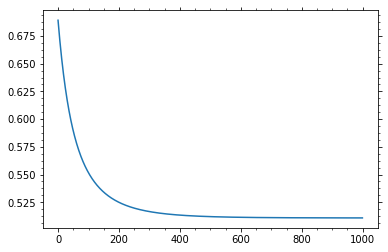

In [18]:
# learning curve
fg1 = plt.figure()
ax1 = fg1.add_subplot(111)
ax1.plot(losses)

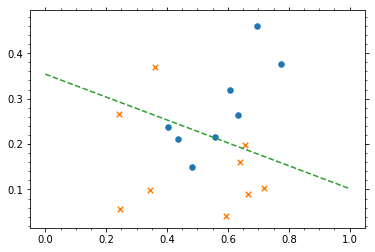

In [19]:
# decision boundary
_x = np.linspace(0., 1., 2)
ax.plot(_x, -(w[0]+w[1]*_x)/w[2], ls='--', c='C2')
fg

In [20]:
# accuracy
y2_pred = logistic_model(X2_, w) > 0.5
accuracy = (y2_pred == y2).sum()/len(y2) # right/all
print("Accuracy = {:.2%}".format(accuracy))

Accuracy = 70.59%


In [21]:
# metrics
prec = ((y2_pred==1) & (y2 == 1)).sum()/(y2_pred == 1).sum() # tp / pred pos
print('precision={:.2%}'.format(prec))
reca = ((y2_pred==1) & (y2 == 1)).sum()/(y2 == 1).sum() # tp / pos
print('recall={:.2%}'.format(reca))
f1score = 2/(1/prec + 1/reca)
print('f1={:.2%}'.format(f1score))
f2score = (1+2**2)/(1/prec + 2**2/reca)
print('f2={:.2%}'.format(f2score))

precision=71.43%
recall=62.50%
f1=66.67%
f2=64.10%


#### sklearn

In [22]:
# learning the logistic model with sklearn
log = linear_model.LogisticRegression(C=10000.)
log.fit(X2, y2.ravel())

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [23]:
print(log.coef_, log.intercept_) # (w1, w2, b)

[[ 3.14089155 12.45455489]] [-4.40581073]


In [24]:
y2_pred_ = log.predict(X2)
print('accuracy={:.2%}'.format(metrics.accuracy_score(y2, y2_pred_)))
print('precision={:.2%}'.format(metrics.precision_score(y2, y2_pred_)))
print('recall={:.2%}'.format(metrics.recall_score(y2, y2_pred_)))
print('f1={:.2%}'.format(metrics.f1_score(y2, y2_pred_)))
print('f2={:.2%}'.format(metrics.fbeta_score(y2, y2_pred_, beta=2)))

accuracy=70.59%
precision=71.43%
recall=62.50%
f1=66.67%
f2=64.10%


### 多项对数几率回归/Softmax回归
将对数几率回归这个二分类模型推广到多分类模型：  
$p(y=k \mid {\bf x}) = \frac{\exp({\bf \hat w}_k^T {\bf x})}{1 + \sum_{i=1}^{K-1} \exp({\bf \hat w}_i^T {\bf x}) }$ (for $k=1, 2, \cdots, K-1$) and   
$p(y=K \mid {\bf x}) = \frac{1}{1 + \sum_{i=1}^{K-1} \exp({\bf \hat w}_i^T {\bf x}) }$。  
损失函数：$J({\bf \hat w}) = -1/m \sum_{i=1}^{m} \sum_j 1\{ y_i = j\} \ln p (y=j \mid {\bf x}_i; {\bf \hat w})$。  
梯度下降：$\boxed{w_{k, i+1} = w_{k, i} - \eta \nabla_{\bf w_k}J = w_{k, i} + \eta {\bf X}^T ({\bf 1}\{ y=k \} - {\bf p}(y=k)) / m}$ (for $k=1, 2, \cdots, K-1$)。

In [ ]:
# TODO: example

## 线性判别式分析 （Linear Discriminant Analysis, LDA）
给定训练样例集，设法将样例投影到一条直线上，使得同类样例尽可能靠近、异类样例尽量远离。对新样本分类时，将其投影到同样的直线上，在根据投影点位置确定新样本类型。

把一个点$({\bf x}, y)$投影到方向向量为${\bf w}$的直线上：${\bf w}^T {\bf x}$，优化目标（使$J$最大）：
$$ J = \frac{\| {\bf w}^T {\bf \mu}_0 - {\bf w}^T {\bf \mu}_1 \| ^2}{{\bf w}^T ({\bf \Sigma_0 + \Sigma_1}) {\bf w}} = \frac{{\bf w}^T {\bf S}_b {\bf w}}{{\bf w}^T {\bf S}_w {\bf w}}  $$

其中
${\bf S}_w = \sum_{{\bf x} \in X_0} ({\bf x-{\mu}}_0)({\bf x-{\mu}}_0)^T + \sum_{{\bf x} \in X_1} ({\bf x-{\mu}}_1)({\bf x-{\mu}}_1)^T$，
${\bf S}_b = ({\bf \mu_0 - \mu_1})({\bf \mu_0 - \mu_1})^T $，  
可得，$\boxed {{\bf w}=S_w^{-1} ({\bf \mu_0 - \mu_1})}$ (考虑到$S_b {\bf w}$方向和${\bf \mu_0 - \mu_1}$一致)

In [25]:
!head datasets/MLiA/Ch05/testSet.txt # MLiA, Chapter05

In [26]:
raw_data = np.loadtxt('datasets/MLiA/Ch05/testSet.txt')

In [27]:
X2_0 = raw_data[raw_data[:, 2]==0, :2]
X2_1 = raw_data[raw_data[:, 2]==1, :2]

# watermelon 3.0 alpha
#X2_0 = X2[8:, :2]
#X2_1 = X2[:8, :2]

mu0 = X2_0.mean(axis=0)
mu1 = X2_1.mean(axis=0)

Sw = (X2_0-mu0).T@(X2_0-mu0) + (X2_1-mu1).T@(X2_1-mu1) # X=(nsamples, nfeatures)
print(Sw)

[[135.35903647 131.52568101]
 [131.52568101 660.67023227]]


In [28]:
# singular value decomposition
u, s, v = np.linalg.svd(Sw) # Sw = u@diag(s)@v
Sw_inv = v.T@np.diag(1./s)@u.T
print('Sw^-1 = \n', Sw_inv)
#print(np.linalg.inv(Sw))

Sw^-1 = 
 [[ 0.00915961 -0.00182349]
 [-0.00182349  0.00187663]]


In [29]:
w_star = Sw_inv@(mu0-mu1)
print('w^star = ', w_star)

w^star =  [-0.01313392  0.01426317]


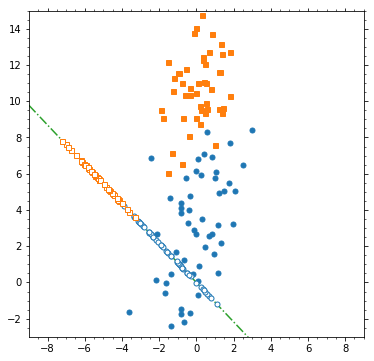

In [30]:
fg2 = plt.figure(figsize=(6, 6))
ax2 = fg2.add_subplot(111)
ax2.plot(X2_1[:, 0], X2_1[:, 1], marker='o', ms=5, c='C0', ls='None')
ax2.plot(X2_0[:, 0], X2_0[:, 1], marker='s', ms=5, c='C1', ls='None')

# the line to project, let (x-0)/w0 = (y-0)/w1
ax2.set_xlim([-9, 9])
ax2.set_ylim([-3, 15])
xrange = np.array(ax2.get_xlim())
yrange = w_star[1]/w_star[0]*xrange
ax2.plot(xrange, yrange, ls='-.', c='C2')

# points projected to the line
w_star_norm = w_star/np.sqrt((w_star**2).sum())
X2_0_proj = (X2_0@w_star_norm).reshape(-1, 1) * w_star_norm
X2_1_proj = (X2_1@w_star_norm).reshape(-1, 1) * w_star_norm
ax2.plot(X2_1_proj[:, 0], X2_1_proj[:, 1], marker='o', ms=5, c='C0', mfc='w', ls='None')
ax2.plot(X2_0_proj[:, 0], X2_0_proj[:, 1], marker='s', ms=5, c='C1', mfc='w', ls='None')